### Analyzing ACN Data to Predict Charging Behavior Of EV Owners

Unfortunately, I ran out of time to explain some of the things I am doing below but I am hoping you can follow it.

In [165]:
import requests
import pandas as pd
import json
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import seaborn as sns
sns.set_style("darkgrid")

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn')

I tried to use the API to download the data, but unfortunately I couldn't get the api to work with the pagination process. Below is the code to get 25 instances of ACN data using the API

In [167]:
#URL = "https://ev.caltech.edu/api/v1/sessions/caltech?where=connectionTime>='Wed, 1 May 2019 00:00:00 GMT' and connectionTime<='Fri, 3 May 2019 00:00:00 GMT'"
#Data = requests.get(URL, auth=('h2LGXh4JiwNbpL9jxTimYAM1Xb-G-tbx1Glv2fupD2c',' '))

Instead I dowloaded the data directly from the website to my laptop and loaded it as follows.

In [60]:
with open(r'C:\Users\karabulutc\Jupyter Notebooks\TDI - Capstone\acndata_sessions.json') as f:
  data = json.load(f)


In [61]:
df = pd.json_normalize(data['_items'])

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31150 entries, 0 to 31149
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               31150 non-null  object 
 1   clusterID         31150 non-null  object 
 2   connectionTime    31150 non-null  object 
 3   disconnectTime    31150 non-null  object 
 4   doneChargingTime  29158 non-null  object 
 5   kWhDelivered      31150 non-null  float64
 6   sessionID         31150 non-null  object 
 7   siteID            31150 non-null  object 
 8   spaceID           31150 non-null  object 
 9   stationID         31150 non-null  object 
 10  timezone          31150 non-null  object 
 11  userID            16134 non-null  object 
 12  userInputs        16134 non-null  object 
dtypes: float64(1), object(12)
memory usage: 3.1+ MB


In [63]:
df.head(10)

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5bc90cb9f9af8b0d7fe77cd2,0039,"Wed, 25 Apr 2018 11:08:04 GMT","Wed, 25 Apr 2018 13:20:10 GMT","Wed, 25 Apr 2018 13:21:10 GMT",7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None
1,5bc90cb9f9af8b0d7fe77cd3,0039,"Wed, 25 Apr 2018 13:45:10 GMT","Thu, 26 Apr 2018 00:56:16 GMT","Wed, 25 Apr 2018 16:44:15 GMT",10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None
2,5bc90cb9f9af8b0d7fe77cd4,0039,"Wed, 25 Apr 2018 13:45:50 GMT","Wed, 25 Apr 2018 23:04:45 GMT","Wed, 25 Apr 2018 14:51:44 GMT",5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None
3,5bc90cb9f9af8b0d7fe77cd5,0039,"Wed, 25 Apr 2018 14:37:06 GMT","Wed, 25 Apr 2018 23:55:34 GMT","Wed, 25 Apr 2018 16:05:22 GMT",5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None
4,5bc90cb9f9af8b0d7fe77cd6,0039,"Wed, 25 Apr 2018 14:40:34 GMT","Wed, 25 Apr 2018 23:03:12 GMT","Wed, 25 Apr 2018 17:40:30 GMT",10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None
5,5bc90cb9f9af8b0d7fe77cd7,0039,"Wed, 25 Apr 2018 14:43:50 GMT","Thu, 26 Apr 2018 01:17:30 GMT","Wed, 25 Apr 2018 16:18:28 GMT",7.910,2_39_139_28_2018-04-25 14:43:49.647430,0002,CA-303,2-39-139-28,America/Los_Angeles,None,None
6,5bc90cb9f9af8b0d7fe77cd8,0039,"Wed, 25 Apr 2018 14:47:42 GMT","Wed, 25 Apr 2018 18:27:51 GMT","Wed, 25 Apr 2018 18:27:42 GMT",15.294,2_39_91_441_2018-04-25 14:47:41.776352,0002,CA-499,2-39-91-441,America/Los_Angeles,None,None
7,5bc90cb9f9af8b0d7fe77cd9,0039,"Wed, 25 Apr 2018 14:58:25 GMT","Wed, 25 Apr 2018 19:06:29 GMT","Wed, 25 Apr 2018 16:48:29 GMT",6.953,2_39_79_377_2018-04-25 14:58:25.255583,0002,CA-325,2-39-79-377,America/Los_Angeles,None,None
8,5bc90cb9f9af8b0d7fe77cda,0039,"Wed, 25 Apr 2018 15:10:52 GMT","Wed, 25 Apr 2018 18:15:46 GMT","Wed, 25 Apr 2018 16:07:56 GMT",2.174,2_39_79_382_2018-04-25 15:10:51.871020,0002,CA-491,2-39-79-382,America/Los_Angeles,None,None
9,5bc90cb9f9af8b0d7fe77cdb,0039,"Wed, 25 Apr 2018 15:12:11 GMT","Wed, 25 Apr 2018 18:29:21 GMT","Wed, 25 Apr 2018 18:30:20 GMT",2.439,2_39_78_362_2018-04-25 15:12:10.901351,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None


In [64]:
df['kWhDelivered'].describe()

count    31150.000000
mean         9.229118
std          8.701241
min          0.501000
25%          3.405250
50%          6.719000
75%         12.929000
max         77.700000
Name: kWhDelivered, dtype: float64

<AxesSubplot:>

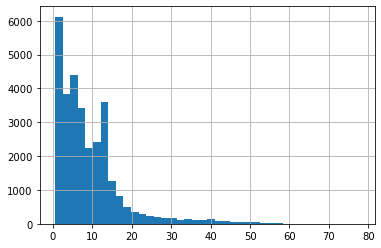

In [65]:
df['kWhDelivered'].hist(bins=40)

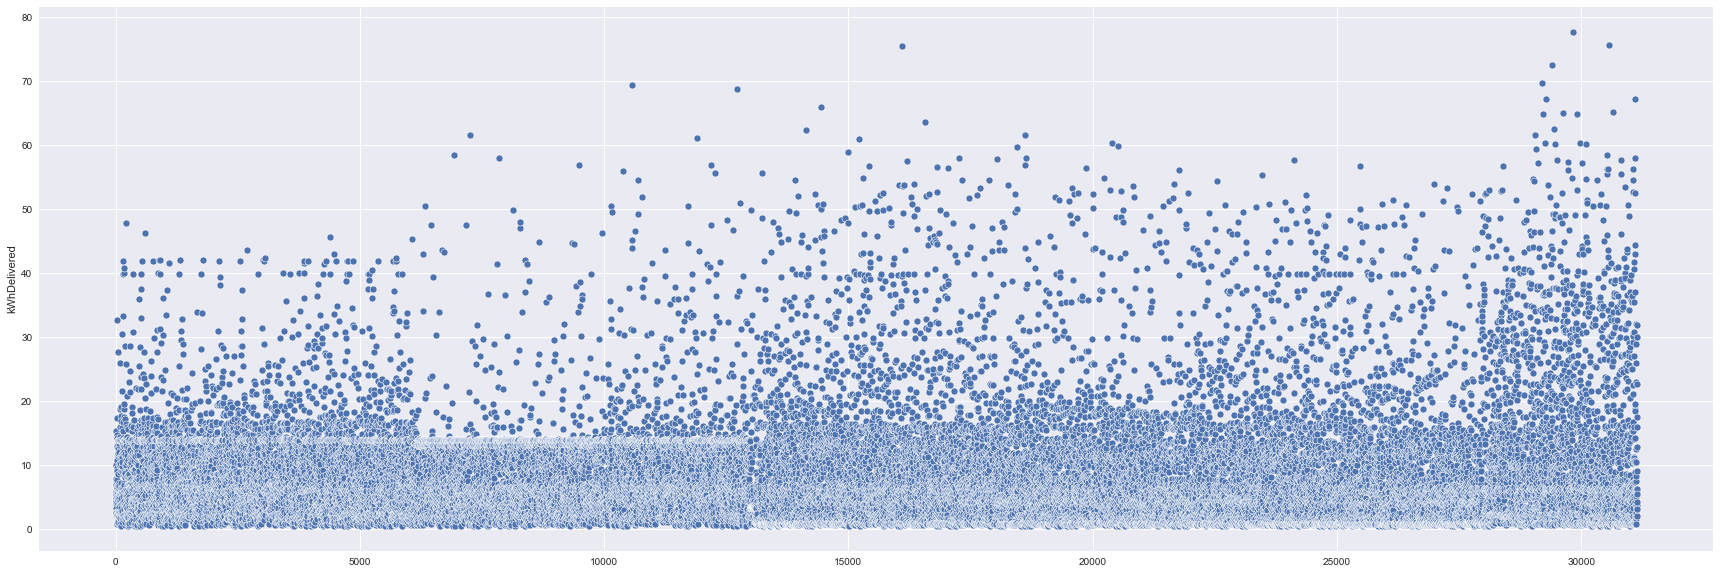

In [163]:
ax = plt.subplots(1, 1, figsize = (30, 10))
sns.scatterplot(x=df['kWhDelivered'].index, y=df['kWhDelivered'],
                 palette = ("BuPu"));

In [69]:
df['timeSpentCharging'] = ((pd.to_datetime(df['disconnectTime']) - 
                            pd.to_datetime(df['connectionTime']))
                                .dt.total_seconds() / 3600)

In [77]:
df.head(10)

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,timeSpentCharging
0,5bc90cb9f9af8b0d7fe77cd2,0039,"Wed, 25 Apr 2018 11:08:04 GMT","Wed, 25 Apr 2018 13:20:10 GMT","Wed, 25 Apr 2018 13:21:10 GMT",7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None,2.201667
1,5bc90cb9f9af8b0d7fe77cd3,0039,"Wed, 25 Apr 2018 13:45:10 GMT","Thu, 26 Apr 2018 00:56:16 GMT","Wed, 25 Apr 2018 16:44:15 GMT",10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None,11.185000
2,5bc90cb9f9af8b0d7fe77cd4,0039,"Wed, 25 Apr 2018 13:45:50 GMT","Wed, 25 Apr 2018 23:04:45 GMT","Wed, 25 Apr 2018 14:51:44 GMT",5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None,9.315278
3,5bc90cb9f9af8b0d7fe77cd5,0039,"Wed, 25 Apr 2018 14:37:06 GMT","Wed, 25 Apr 2018 23:55:34 GMT","Wed, 25 Apr 2018 16:05:22 GMT",5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None,9.307778
4,5bc90cb9f9af8b0d7fe77cd6,0039,"Wed, 25 Apr 2018 14:40:34 GMT","Wed, 25 Apr 2018 23:03:12 GMT","Wed, 25 Apr 2018 17:40:30 GMT",10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None,8.377222
5,5bc90cb9f9af8b0d7fe77cd7,0039,"Wed, 25 Apr 2018 14:43:50 GMT","Thu, 26 Apr 2018 01:17:30 GMT","Wed, 25 Apr 2018 16:18:28 GMT",7.910,2_39_139_28_2018-04-25 14:43:49.647430,0002,CA-303,2-39-139-28,America/Los_Angeles,None,None,10.561111
6,5bc90cb9f9af8b0d7fe77cd8,0039,"Wed, 25 Apr 2018 14:47:42 GMT","Wed, 25 Apr 2018 18:27:51 GMT","Wed, 25 Apr 2018 18:27:42 GMT",15.294,2_39_91_441_2018-04-25 14:47:41.776352,0002,CA-499,2-39-91-441,America/Los_Angeles,None,None,3.669167
7,5bc90cb9f9af8b0d7fe77cd9,0039,"Wed, 25 Apr 2018 14:58:25 GMT","Wed, 25 Apr 2018 19:06:29 GMT","Wed, 25 Apr 2018 16:48:29 GMT",6.953,2_39_79_377_2018-04-25 14:58:25.255583,0002,CA-325,2-39-79-377,America/Los_Angeles,None,None,4.134444
8,5bc90cb9f9af8b0d7fe77cda,0039,"Wed, 25 Apr 2018 15:10:52 GMT","Wed, 25 Apr 2018 18:15:46 GMT","Wed, 25 Apr 2018 16:07:56 GMT",2.174,2_39_79_382_2018-04-25 15:10:51.871020,0002,CA-491,2-39-79-382,America/Los_Angeles,None,None,3.081667
9,5bc90cb9f9af8b0d7fe77cdb,0039,"Wed, 25 Apr 2018 15:12:11 GMT","Wed, 25 Apr 2018 18:29:21 GMT","Wed, 25 Apr 2018 18:30:20 GMT",2.439,2_39_78_362_2018-04-25 15:12:10.901351,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None,3.286111


In [71]:
df['timeSpentCharging'].describe()

count    31150.000000
mean         5.668510
std          5.979982
min          0.034444
25%          1.877778
50%          4.754583
75%          8.476875
max        245.269167
Name: timeSpentCharging, dtype: float64

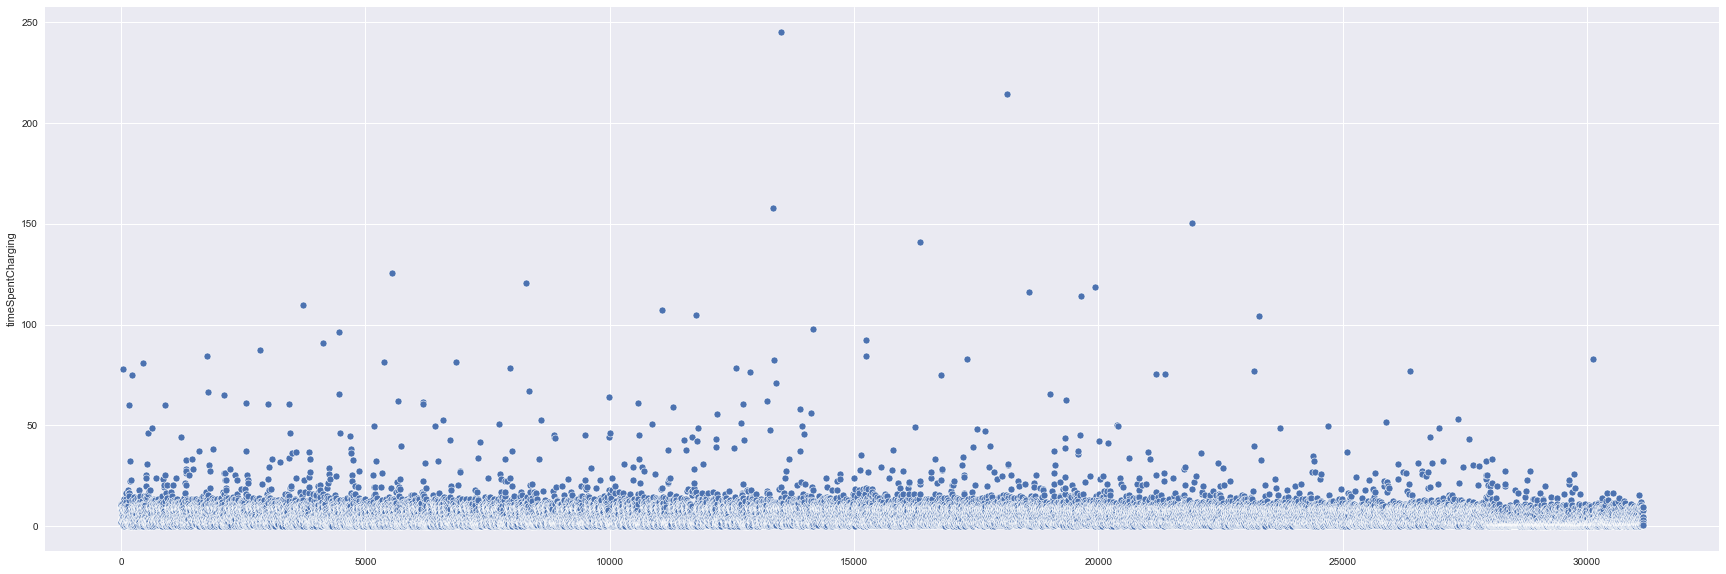

In [164]:
ax = plt.subplots(1, 1, figsize = (30, 10))
sns.scatterplot(x=df['timeSpentCharging'].index, y=df['timeSpentCharging'],
                 palette = ("BuPu"));

In [118]:
df['connectionTimeDate'] =pd.to_datetime(df['connectionTime'])

In [119]:
df['disconnectTimeDate'] =pd.to_datetime(df['disconnectTime'])

In [120]:
df['doneChargingTimeDate'] =pd.to_datetime(df['doneChargingTime'])

In [ ]:
df.drop(['connectionTime','disconnectTime'], axis=1)

In [122]:
df.drop(['connectionTime','disconnectTime','doneChargingTime'], axis=1, inplace=True)

In [123]:
df.head()

,_id,clusterID,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,timeSpentCharging,connectionTimeDate,disconnectTimeDate,doneChargingTimeDate
0,5bc90cb9f9af8b0d7fe77cd2,0039,7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None,2.201667,2018-04-25 11:08:04+00:00,2018-04-25 13:20:10+00:00,2018-04-25 13:21:10+00:00
1,5bc90cb9f9af8b0d7fe77cd3,0039,10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None,11.185000,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,2018-04-25 16:44:15+00:00
2,5bc90cb9f9af8b0d7fe77cd4,0039,5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None,9.315278,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,2018-04-25 14:51:44+00:00
3,5bc90cb9f9af8b0d7fe77cd5,0039,5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None,9.307778,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,2018-04-25 16:05:22+00:00
4,5bc90cb9f9af8b0d7fe77cd6,0039,10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None,8.377222,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,2018-04-25 17:40:30+00:00


In [124]:
df['dayOfWeek'] = df['connectionTimeDate'].dt.day_name()

In [131]:
df['monthOfYear'] = df['connectionTimeDate'].dt.month_name()

In [154]:
df.head()

,_id,clusterID,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,timeSpentCharging,connectionTimeDate,disconnectTimeDate,doneChargingTimeDate,dayOfWeek,monthOfYear
0,5bc90cb9f9af8b0d7fe77cd2,0039,7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None,2.201667,2018-04-25 11:08:04+00:00,2018-04-25 13:20:10+00:00,2018-04-25 13:21:10+00:00,Wednesday,April
1,5bc90cb9f9af8b0d7fe77cd3,0039,10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None,11.185000,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,2018-04-25 16:44:15+00:00,Wednesday,April
2,5bc90cb9f9af8b0d7fe77cd4,0039,5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None,9.315278,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,2018-04-25 14:51:44+00:00,Wednesday,April
3,5bc90cb9f9af8b0d7fe77cd5,0039,5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None,9.307778,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,2018-04-25 16:05:22+00:00,Wednesday,April
4,5bc90cb9f9af8b0d7fe77cd6,0039,10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None,8.377222,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,2018-04-25 17:40:30+00:00,Wednesday,April


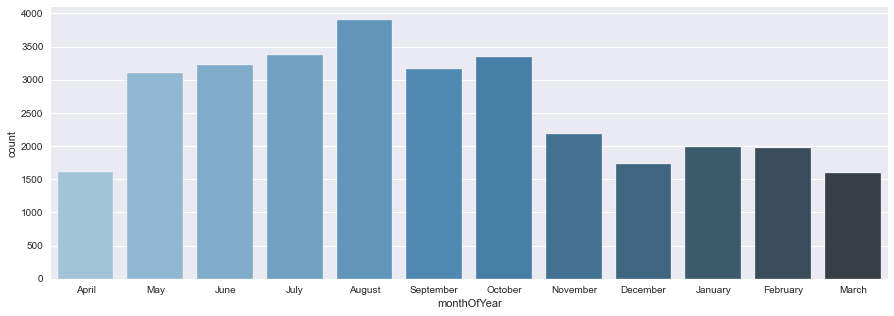

In [152]:
fig, ax = plt.subplots( figsize = (15,5))
ax = sns.countplot(data = df, x = 'monthOfYear', ax=ax, palette = ("Blues_d"))



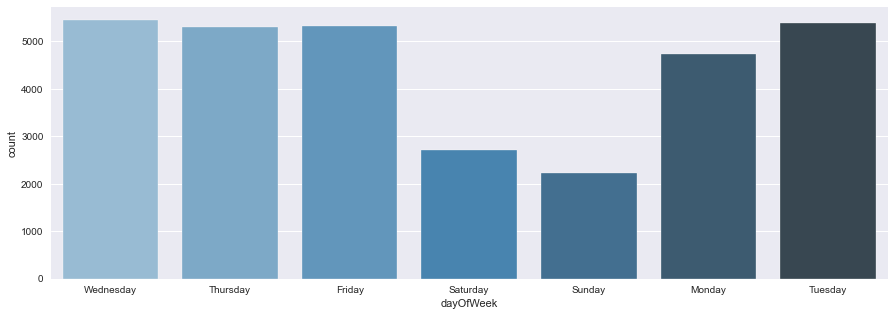

In [153]:
fig, ax = plt.subplots( figsize = (15,5))
ax = sns.countplot(data = df, x = 'dayOfWeek', ax=ax, palette = ("Blues_d"))
